In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')


import sys
sys.path.insert(0, "..")
from src.data import make_dataset
from pathlib import Path
import gin

datadir = Path("../data/raw/roomtemp")
data = make_dataset.get_roomtemp(datadir=datadir)
data = data.rename({'DAYTON_MW': 'temp', 'Datetime1': 'hour'}, axis=1)
data=data.drop(data.columns[[0, 3]], axis=1)
data.head()




2022-12-14 15:47:42.104 | INFO     | src.data.make_dataset:get_roomtemp:28 - Found ../data/raw/roomtemp/MLTempDataset.csv, load from disk


,hour,temp
0,0,20.867
1,1,21.000
2,2,20.867
3,3,20.650
4,4,20.400


In [2]:
import torch
series = data['temp']
tensordata = torch.from_numpy(series.to_numpy()).type(torch.float32)
tensordata

tensor([20.8670, 21.0000, 20.8670,  ..., 26.4500, 25.9000, 25.5670])

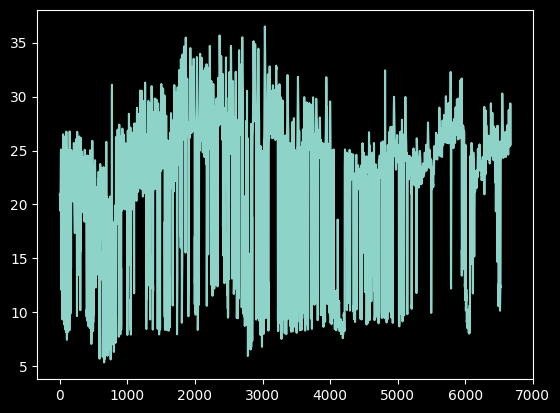

In [3]:
plt.plot(tensordata);

In [4]:
tensordata.__len__()

6676

In [5]:
# Train test split
split = 5000
train = tensordata[:split]

norm = max(train)
test = tensordata[split:]

train = train / norm
test = test/ norm


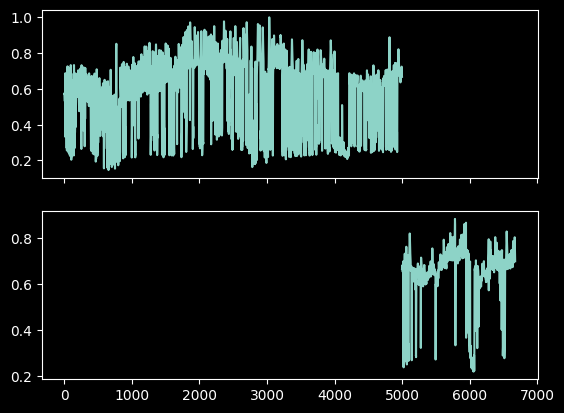

In [6]:
# reduce steps back to hours
idx0 = torch.arange(0, len(train))
idx1 = torch.arange(0, len(test)) + idx0.max()
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(idx0, train)
axs[1].plot(idx1,test)

In [7]:
from src.data import data_tools

window_size = 28 # this is just a wild guess. A bit over 24 hours
idx = data_tools.window(train, window_size)
trainset = train[idx]
idx = data_tools.window(test, window_size)
testset = test[idx]
trainset.shape, testset.shape

2022-12-14 15:47:46.138701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 15:47:48.907292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 15:47:48.907461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 15:47:48.907473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

(torch.Size([4973, 28]), torch.Size([1649, 28]))

In [8]:
from torch.utils.data import DataLoader
trainset = trainset[...,None]
testset = testset[..., None]
trainset.shape, testset.shape

(torch.Size([4973, 28, 1]), torch.Size([1649, 28, 1]))

In [9]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, horizon):
        self.data = data
        self.size = len(data)
        self.horizon = horizon
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        # get a single item
        item = self.data[idx]
        # slice off the horizon
        x = item[:-self.horizon,:]
        y = item[-self.horizon:,:].squeeze(-1) # squeeze will remove the last dimension if possible.
        return x, y

In [10]:
horizon = 3
traindataset = CustomDataset(trainset, horizon=horizon)
testdataset = CustomDataset(testset, horizon=horizon)

trainloader = DataLoader(traindataset, batch_size=32, shuffle=True)
testloader = DataLoader(testdataset, batch_size=32, shuffle=True)

In [11]:
x, y = next(iter(trainloader))
x.shape, y.shape # here we see the squeeze in action

(torch.Size([32, 25, 1]), torch.Size([32, 3]))

In [12]:
from typing import Tuple
Tensor = torch.Tensor

def naivepredict(x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
    assert horizon > 0
    yhat = x[...,-horizon:, :].squeeze(-1)
    return yhat


yhat = naivepredict(x, horizon) #this should be the same horizon you used to create the dataset
yhat.shape


def mae(y: Tensor, yhat: Tensor) -> Tensor:
    return torch.mean(torch.abs(y-yhat))


mae(y, yhat)

tensor(0.1173)

In [13]:
def naivenorm(dataloader: DataLoader, horizon: int):
    elist = []
    for x, y in dataloader:
        yhat = naivepredict(x, horizon)
        e = mae(y, yhat)
        elist.append(e)
    return torch.mean(torch.tensor(elist))
naivenorm(trainloader, 1)

tensor(0.0707)

In [14]:
Tensor = torch.Tensor
class MASE:
    def __init__(self, dataloader: DataLoader, horizon: int):
        self.scale = self.naivenorm(dataloader, horizon)
    
    def __repr__(self) -> str:
        # __repr__ is what is returned if you print the class to the screen 
        return f"MASE(scale={self.scale:.3f})"

    def naivenorm(self, dataloader: DataLoader, horizon: int):
        elist = []
        for x, y in dataloader:
            yhat = self.naivepredict(x, horizon)
            e = self.mae(y, yhat)
            elist.append(e)
        return torch.mean(torch.tensor(elist))
    
    def naivepredict(self, x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
        assert horizon > 0
        yhat = x[...,-horizon:, :].squeeze(-1)
        return yhat

    def mae(self, y: Tensor, yhat: Tensor) -> Tensor:
        return torch.mean(torch.abs(y-yhat))
    
    def __call__(self, y: Tensor, yhat: Tensor) -> Tensor:
        # __call__ lets us call the class as a function
        return self.mae(y, yhat) / self.scale

In [15]:
mase = MASE(trainloader, horizon)
mase # __repr__ in action

MASE(scale=0.097)

In [16]:
from src.models import rnn_models, metrics
observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([32, 25, 1]), torch.Size([32, 3]))

In [17]:
yhat = model(x)
yhat.shape

torch.Size([32, 3])

In [18]:
mase = metrics.MASE(trainloader, horizon)
mase(y, yhat)

tensor(8.3463, grad_fn=<DivBackward0>)

In [19]:
mae = metrics.MAE()
mae(yhat, y)

tensor(0.8059, grad_fn=<MeanBackward0>)

In [21]:
from src.models import train_model
from pathlib import Path
gin.parse_config_file("model.gin")

log_dir = Path("../models/rnn/")

observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)


model = train_model.trainloop(
    model=model,
    metrics=[mase, mae],
    train_dataloader=trainloader,
    test_dataloader=testloader,
    log_dir=log_dir,
    train_steps=len(trainloader),
    eval_steps=len(testloader),
    patience=20,
    factor=0.5
)


2022-12-14 15:49:07.967 | INFO     | src.data.data_tools:dir_add_timestamp:114 - Logging to ../../models/rnn/20221214-1549
100%|██████████| 156/156 [00:00<00:00, 320.16it/s]
2022-12-14 15:49:08.829 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 0.0939 test 0.0085 metric ['0.5890', '0.0569']
100%|██████████| 156/156 [00:00<00:00, 180.70it/s]
2022-12-14 15:49:09.822 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 0.0262 test 0.0074 metric ['0.5565', '0.0537']
100%|██████████| 156/156 [00:00<00:00, 341.77it/s]
2022-12-14 15:49:10.392 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 0.0235 test 0.0075 metric ['0.5305', '0.0512']
100%|██████████| 156/156 [00:00<00:00, 290.38it/s]
2022-12-14 15:49:11.049 | INFO     | src.models.train_model:trainloop:171 - Epoch 3 train 0.0216 test 0.0072 metric ['0.5052', '0.0488']
100%|██████████| 156/156 [00:00<00:00, 377.37it/s]
2022-12-14 15:49:11.563 | INFO     | src.models.train_model:trainloop:171 

In [22]:
x, y = next(iter(testloader))
yhat = model(x)
mae(y, yhat), mase(y, yhat)

(tensor(0.0522, grad_fn=<MeanBackward0>),
 tensor(0.5410, grad_fn=<DivBackward0>))

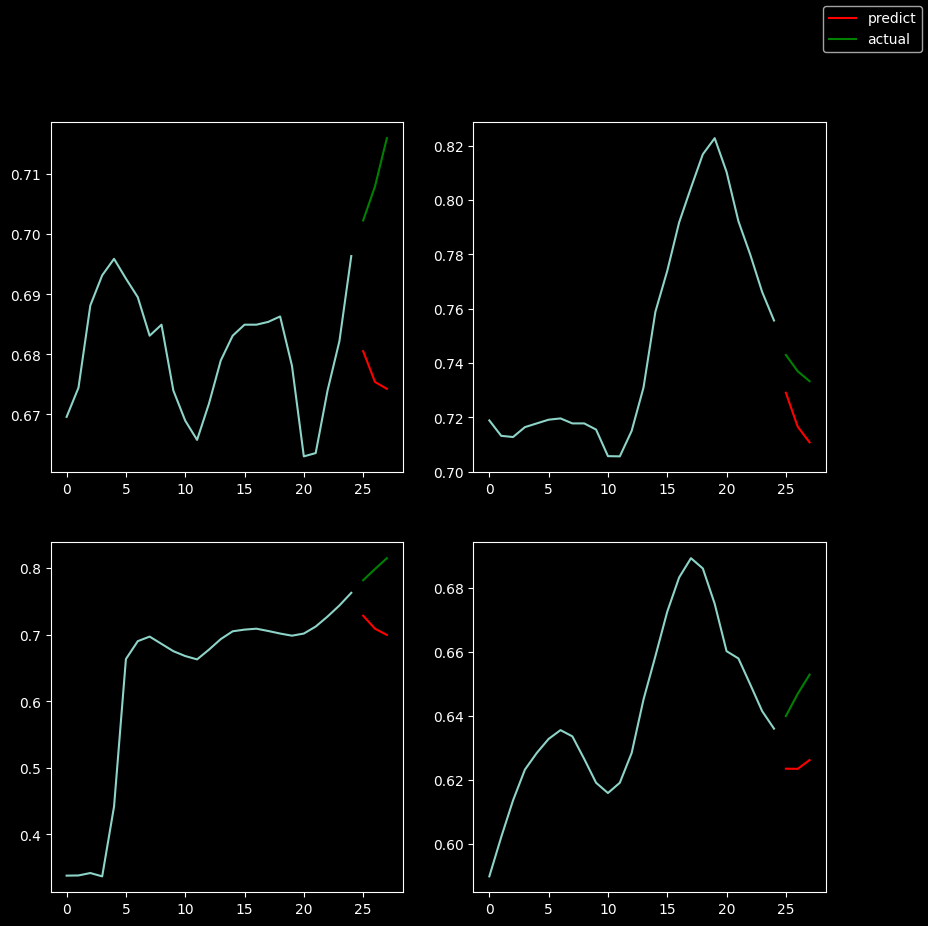

In [23]:
k = 4
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.ravel()

timesteps = x.shape[1]
idx0 = [*range(timesteps)]
idx1 = [(i + timesteps) for i in range(horizon)]
for i in range(k):
    axs[i].plot(idx0, x[i])
    axs[i].plot(idx1, yhat[i].detach(), color="red", label="predict")
    axs[i].plot(idx1, y[i], color="green", label="actual")
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels)

In [24]:
gin.parse_config_file("model.gin")

observations = window_size - horizon
model = rnn_models.BaseRNN(horizon=horizon)

model = train_model.trainloop(
    model=model,
    metrics=[mase, mae],
    learning_rate=1e-3,
    train_dataloader=trainloader,
    test_dataloader=testloader,
    log_dir=log_dir,
    train_steps=len(trainloader),
    eval_steps=len(testloader),
    patience=10,
    factor=0.5
)



2022-12-14 16:09:47.743 | INFO     | src.data.data_tools:dir_add_timestamp:114 - Logging to ../../models/rnn/20221214-1609
100%|██████████| 156/156 [00:02<00:00, 62.20it/s]
2022-12-14 16:09:51.073 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 0.0395 test 0.0078 metric ['0.6520', '0.0630']
100%|██████████| 156/156 [00:02<00:00, 75.26it/s]
2022-12-14 16:09:53.400 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 0.0179 test 0.0068 metric ['0.5311', '0.0513']
100%|██████████| 156/156 [00:02<00:00, 64.56it/s]
2022-12-14 16:09:56.083 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 0.0163 test 0.0056 metric ['0.4204', '0.0406']
100%|██████████| 156/156 [00:01<00:00, 79.03it/s]
2022-12-14 16:09:58.316 | INFO     | src.models.train_model:trainloop:171 - Epoch 3 train 0.0146 test 0.0045 metric ['0.3659', '0.0353']
100%|██████████| 156/156 [00:02<00:00, 73.38it/s]
2022-12-14 16:10:00.715 | INFO     | src.models.train_model:trainloop:171 - Epo

In [25]:
x, y = next(iter(testloader))
yhat = model(x)
mae(y, yhat), mase(y, yhat)

(tensor(0.0322, grad_fn=<MeanBackward0>),
 tensor(0.3337, grad_fn=<DivBackward0>))

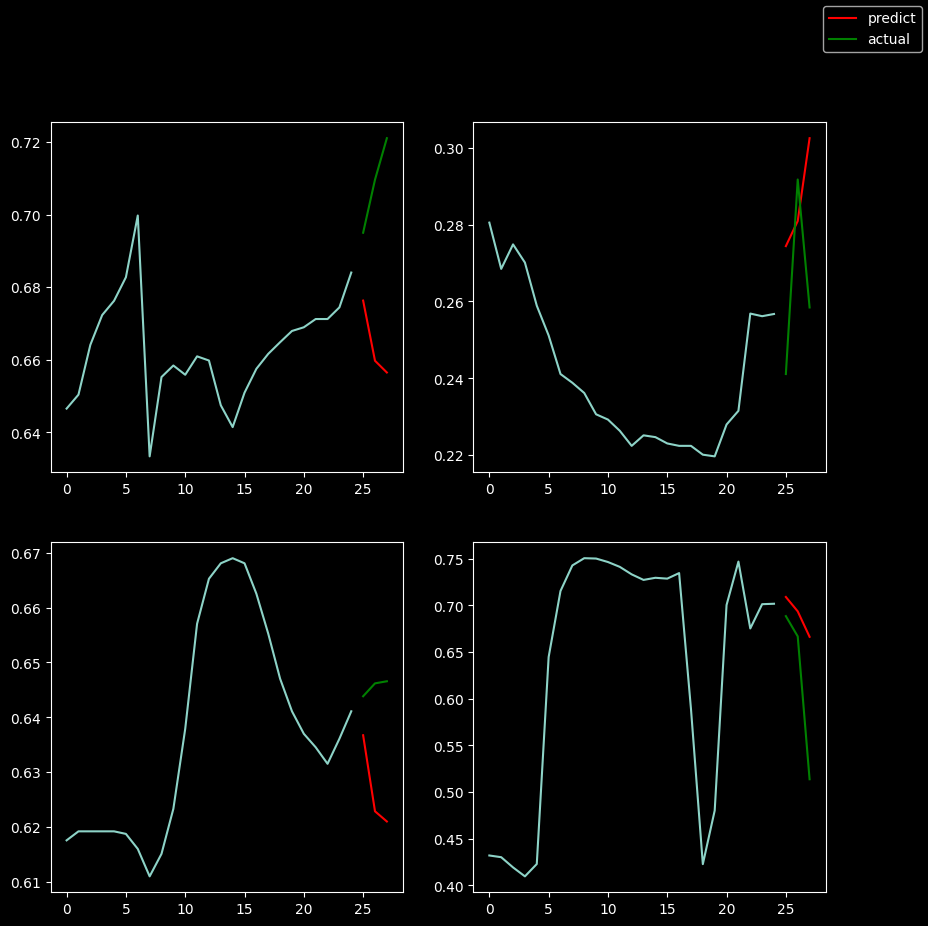

In [27]:
k = 4
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.ravel()

timesteps = x.shape[1]
idx0 = [*range(timesteps)]
idx1 = [(i + timesteps) for i in range(horizon)]
for i in range(k):
    axs[i].plot(idx0, x[i])
    axs[i].plot(idx1, yhat[i].detach(), color="red", label="predict")
    axs[i].plot(idx1, y[i], color="green", label="actual")
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels)

In [28]:
gin.parse_config_file("model.gin")

observations = window_size - horizon
model = rnn_models.GRUmodel(horizon=horizon)

model = train_model.trainloop(
    model=model,
    metrics=[mase, mae],
    learning_rate=1e-3,
    train_dataloader=trainloader,
    test_dataloader=testloader,
    log_dir=log_dir,
    train_steps=len(trainloader),
    eval_steps=len(testloader),
    patience=10,
    factor=0.5
)



TypeError: GRUmodel.__init__() got an unexpected keyword argument 'horizon'
  No values supplied by Gin or caller for arguments: ['config']
  Gin had values bound for: []
  Caller supplied values for: ['horizon', 'self']
  In call to configurable 'GRUmodel' (<class 'src.models.rnn_models.GRUmodel'>)